In [1]:
pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

np.random.seed(10)

# Estimating true causal effect

## Continuous linear models

1. For the following linear model, what is the true causal effect of $X$ on $Y$?

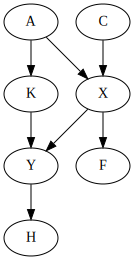

In [3]:
fd_cont = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.7, size=n_samples),
    "A": lambda n_samples: np.random.binomial(n=1, p=0.2, size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "X": discrete_model(["C", "A"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.7, 0.3),
        (1, 0): (0.5, 0.5),
        (1, 1): (0.8, 0.2),
        }),  
    "F": lambda X, n_samples: 3 * X + .8 * np.random.normal(),
    "Y": lambda K, X, n_samples: 2 * K - X + .2 * np.random.normal(),
    "H": lambda Y, n_samples: .5 * Y + .1 * np.random.normal()
})

fd_cont.cgm.draw()

Your answer: *As we know for linear models the true causal effect is the coefficient in front of the variable which is -1  here(in the linear model for Y).

Let us modify the model to simulate a randomized experiment and identify the true causal effect? *Hint:* to simulate a randomized experiment, we can change the function for $X$ as follows `"X": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples)`. After that, we can calculate ATE between $X$ and $Y$ as follows: $ATE = E[Y|X=1] - E[Y|X=0]$.

Now the treatment assignment is random, as required in randomized experiments.

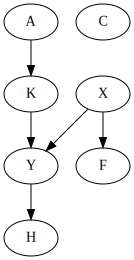

In [4]:
# modify the model
fd_cont_exp = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.7, size=n_samples),
    "A": lambda n_samples: np.random.binomial(n=1, p=0.2, size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "X": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),  
    "F": lambda X, n_samples: 3 * X + .8 * np.random.normal(),
    "Y": lambda K, X, n_samples: 2 * K - X + .2 * np.random.normal(),
    "H": lambda Y, n_samples: .5 * Y + .1 * np.random.normal()
})

fd_cont_exp.cgm.draw()

In [5]:
df1 = fd_cont_exp.sample(n_samples=100000)
ate = df1[df1['X'] == 1]['Y'].mean() - df1[df1['X'] == 0]['Y'].mean()
ate

-0.9926635197459417

This is so close to the true causal effect.

The obtained value should be close to the true ATE: -1.


2. Will increasing/decreasing the sample size affect your estimation accuracy?

Your solution:

In [6]:
df2 = fd_cont_exp.sample(n_samples=1000)
ate = df2[df2['X'] == 1]['Y'].mean() - df2[df2['X'] == 0]['Y'].mean()
ate

-1.0219323077911495

In [7]:
df3 = fd_cont_exp.sample(n_samples=100)
ate = df3[df3['X'] == 1]['Y'].mean() - df3[df3['X'] == 0]['Y'].mean()
ate

-1.0576923076923075

In [8]:
df4 = fd_cont_exp.sample(n_samples=100000000)
ate = df4[df4['X'] == 1]['Y'].mean() - df4[df4['X'] == 0]['Y'].mean()
ate

-1.00008288575

Answer: The estimation is less close to the true causal effect as we
decrease the sample size and it will be closer to the true causal effect
as we increase the sample size.

Let us now try a naive estimation. That is let us calculate the same value $E[Y|X=1] - E[Y|X=0]$, but from a sample from the original (non modified!) model. 

In [9]:
df5 = fd_cont.sample(n_samples=100000)
ate = df5[df5['X'] == 1]['Y'].mean() - df5[df5['X'] == 0]['Y'].mean()
ate

-1.501643343346724

The deviation from the true ATE is now almost 50%. This is due to the fact that data sampled from the original model has the confounders (common causes of $X$ and $Y$).

## Discrete models

1. For the following discrete model `fd_discr`, estimate the true causal effect of $X$ on $Y$? *Simulate a randomized experiment as in the previous example.*
2. Estimate causal effect using a naive approach: for a sample from the original `fd_discr` model (not the modified model!), calculate association between $X$ and $Y$: $E[Y|X=1] - E[Y|X=0]$. 
3. Estimate causal effect with backdoor adjustment (conditioning on confounder): $ATE = E_C[E[Y|X=1, C] - E[Y|X=0,C]]$
4. Which estimation is close to the true value of $\approx -0.30$? Why?
5. Will increasing/decreasing sample size affect your estimation accuracy?

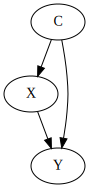

In [10]:
fd_discr = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "X": discrete_model(["C"], {(0,): (0.1,0.9), (1,): (0.9,0.1)}),
    "Y": discrete_model(["X", "C"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.5, 0.5),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.3, 0.7),
    }),
})

fd_discr.cgm.draw()

Your solution

# 1

In [12]:
df6 = fd_discr.sample(n_samples=100000)
ate = df6[df6['X'] == 1]['Y'].mean() - df6[df6['X'] == 0]['Y'].mean()
ate

-0.37398216959811115

The estimation is so close to -0.3.

Randomized X

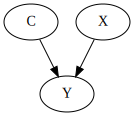

In [13]:
fd_discr_rand = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "X": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "Y": discrete_model(["X", "C"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.5, 0.5),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.3, 0.7),
    }),
})

fd_discr_rand.cgm.draw()

In [14]:
df7 = fd_discr_rand.sample(n_samples=100000)
ate = df7[df7['X'] == 1]['Y'].mean() - df7[df7['X'] == 0]['Y'].mean()
ate

-0.2992378361497657

This one is also so close to -0.3

# 2

In [16]:
df8 = fd_discr.sample(n_samples=100000)
ate = df8[df8['X'] == 1]['Y'].mean() - df8[df8['X'] == 0]['Y'].mean()
ate

-0.3812386042857621

We have an error of 8%.

# 3

E[Y|X=1,C]−E[Y|X=0,C]

In [17]:
p1 = (df8[(df8['X'] == 1) & (df8['C'] == 0)]['Y'].mean() - df8[(df8['X'] == 0) & (df8['C'] == 0) ]['Y'].mean()) * len(df8['C'] == 0) / len(df8)
p2 = (df8[(df8['X'] == 1) & (df8['C'] == 1)]['Y'].mean() - df8[(df8['X'] == 0) & (df8['C'] == 1) ]['Y'].mean()) * len(df8['C'] == 1) / len(df8)

In [18]:
ate = p1+p2
ate

-0.5887290747876592

# 4

The estimation without the backdoor adjustment is closer to -0.3. 

# 5

In [19]:
df8 = fd_discr.sample(n_samples=100)
p1 = (df8[(df8['X'] == 1) & (df8['C'] == 0)]['Y'].mean() - df8[(df8['X'] == 0) & (df8['C'] == 0) ]['Y'].mean()) * len(df8['C'] == 0) / len(df8)
p2 = (df8[(df8['X'] == 1) & (df8['C'] == 1)]['Y'].mean() - df8[(df8['X'] == 0) & (df8['C'] == 1) ]['Y'].mean()) * len(df8['C'] == 1) / len(df8)
ate = p1+p2
ate


-0.3813320825515947

In [20]:
df9 = fd_discr.sample(n_samples=10000000)
p1 = (df9[(df9['X'] == 1) & (df9['C'] == 0)]['Y'].mean() - df9[(df9['X'] == 0) & (df9['C'] == 0) ]['Y'].mean()) * len(df9['C'] == 0) / len(df9)
p2 = (df9[(df9['X'] == 1) & (df9['C'] == 1)]['Y'].mean() - df9[(df9['X'] == 0) & (df9['C'] == 1) ]['Y'].mean()) * len(df9['C'] == 1) / len(df9)
ate = p1+p2
ate

-0.6004680506957217

Here, with backdoor adjustment increasing the sample size diminishes the accuracy.

# modify

Modify the descrete model `fd_discr` such that $C$ would have 3 possible values, name the model `fd_discr_3`. *Note: you can use np.random.choice(), see an example below*

(array([3356.,    0.,    0.,    0.,    0., 3297.,    0.,    0.,    0.,
        3347.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

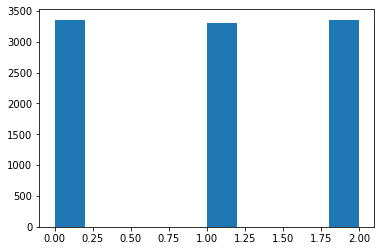

In [21]:
n_samples = 10000
x = np.random.choice([0, 1, 2], size=n_samples)
plt.hist(x)

1. For the resulting discrete model `fd_discr_3`, estimate the true causal effect of $X$ on $Y$? *Note: simulate a randomized experiment.*
2. Estimate causal effect without backdoor adjustment (naive way)
3. Estimate causal effect with backdoor adjustment (conditioning on confounder)
4. Will increasing/decreasing sample size affect your estimation accuracy?

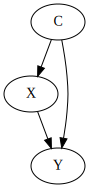

In [31]:
fd_discr_3 = StructuralCausalModel({
    "C": lambda n_samples: np.random.choice([0, 1, 2] , size=n_samples),
    "X": discrete_model(["C"], {(0,): (0.1,0.9), (1,): (0.9,0.1), (2,): (0.4,0.6)}),
    "Y": discrete_model(["X", "C"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.5, 0.5),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.3, 0.7),
        (1, 2): (0.2,0.8),
        (0, 2): (0.5,0.5)
    }),
})

fd_discr_3.cgm.draw()

In [33]:
df = fd_discr_3.sample(n_samples=100000)
ate = df[df['X'] == 1]['Y'].mean() - df[df['X'] == 0]['Y'].mean()
ate

-0.1285295271750423

In [34]:
df10 = fd_discr_3.sample(n_samples=100000)
p3 = (df10[(df10['X'] == 1) & (df10['C'] == 0)]['Y'].mean() - df10[(df10['X'] == 0) & (df10['C'] == 0) ]['Y'].mean()) * len(df10['C'] == 0) / len(df10)
p4 = (df10[(df10['X'] == 1) & (df10['C'] == 1)]['Y'].mean() - df10[(df10['X'] == 0) & (df10['C'] == 1) ]['Y'].mean()) * len(df10['C'] == 1) / len(df10)
ate = p3+p4
ate

-0.6024261302238223

In [35]:
df10 = fd_discr_3.sample(n_samples=1000)
p3 = (df10[(df10['X'] == 1) & (df10['C'] == 0)]['Y'].mean() - df10[(df10['X'] == 0) & (df10['C'] == 0) ]['Y'].mean()) * len(df10['C'] == 0) / len(df10)
p4 = (df10[(df10['X'] == 1) & (df10['C'] == 1)]['Y'].mean() - df10[(df10['X'] == 0) & (df10['C'] == 1) ]['Y'].mean()) * len(df10['C'] == 1) / len(df10)
ate = p3+p4
ate

-0.5037940707740007

In [36]:
df10 = fd_discr_3.sample(n_samples=10000000)
p3 = (df10[(df10['X'] == 1) & (df10['C'] == 0)]['Y'].mean() - df10[(df10['X'] == 0) & (df10['C'] == 0) ]['Y'].mean()) * len(df10['C'] == 0) / len(df10)
p4 = (df10[(df10['X'] == 1) & (df10['C'] == 1)]['Y'].mean() - df10[(df10['X'] == 0) & (df10['C'] == 1) ]['Y'].mean()) * len(df10['C'] == 1) / len(df10)
ate = p3+p4
ate

-0.599628181792522

Again it is closer to the true value without the backdoor adjustment and as we increase the sample size the accuracy will be decreased.